In [1]:
from IPython.display import display
import os
import random
import sys

from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login
import numpy as np
import torch

sys.path.append("./")
from simulation import *;

In [2]:
# シード値の固定
SEED = 42
np.random.seed(seed=SEED)
random.seed(SEED)

## 遺伝アルゴリズムの実行

In [3]:
# 生息地を表すワード
HABITAT_WORDS = " Alien from Mars"

# パラメーター
POPURATIONS = 500
GENOMS_SIZE = 4 # 遺伝配列 0, 1 のどちらかを要素とした配列のサイズ
NUM_GENERATION = 1000 # 世代数
TOUNAMENT_NUM = 10 # トーナメント方式で競わせる数
CROSSOVER_PB = 0.8 # cross over(交差) する確率
MUTATION_PB = 0.5 # mutation(突然変異)する確率

Generation loop start.
Generation loop ended. The best individual: 
{'body_hair': [0.0, 1.0, 1.0, 0], 'body_size': [0.0, 0.0, 1.0, 1], 'herd_num': [1.0, 0.0, 1.0, 1], 'eating': [1.0, 0.0, 0.0, 0], 'body_color': [1.0, 1.0, 1.0, 0], 'ferocity': [1.0, 0.0, 1.0, 0]}


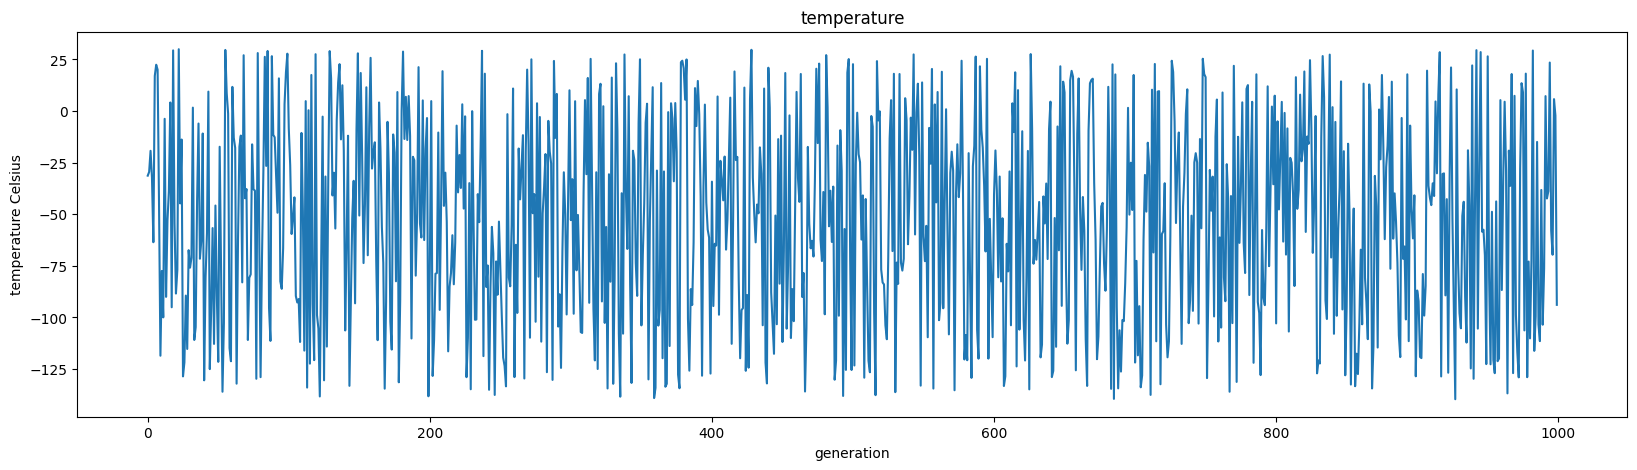

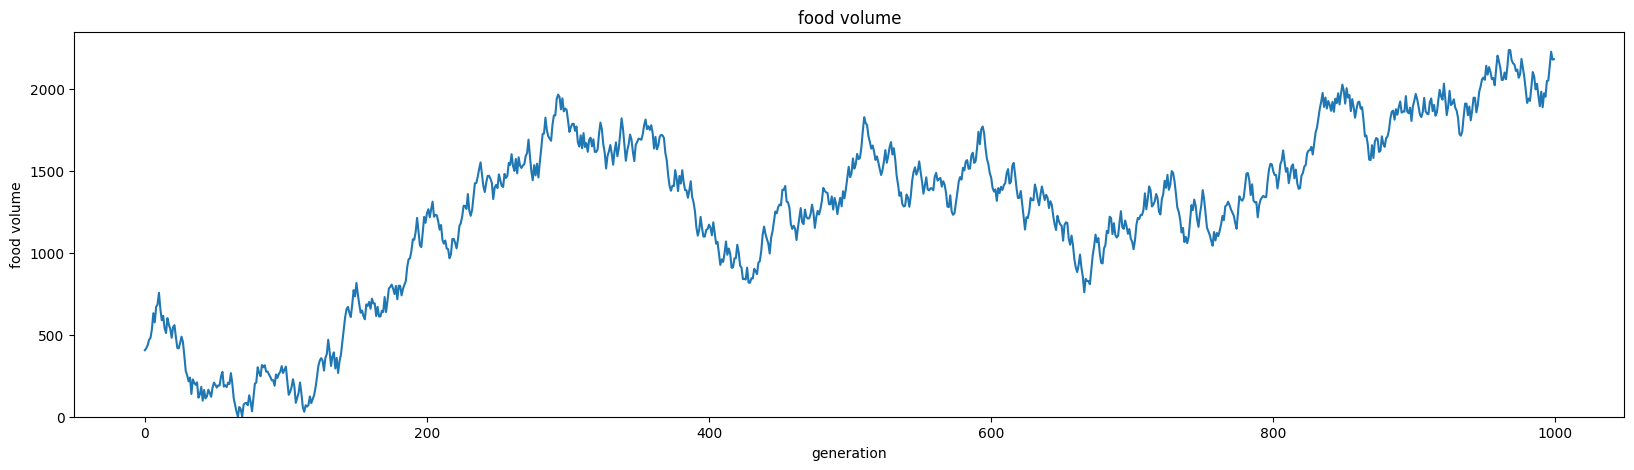

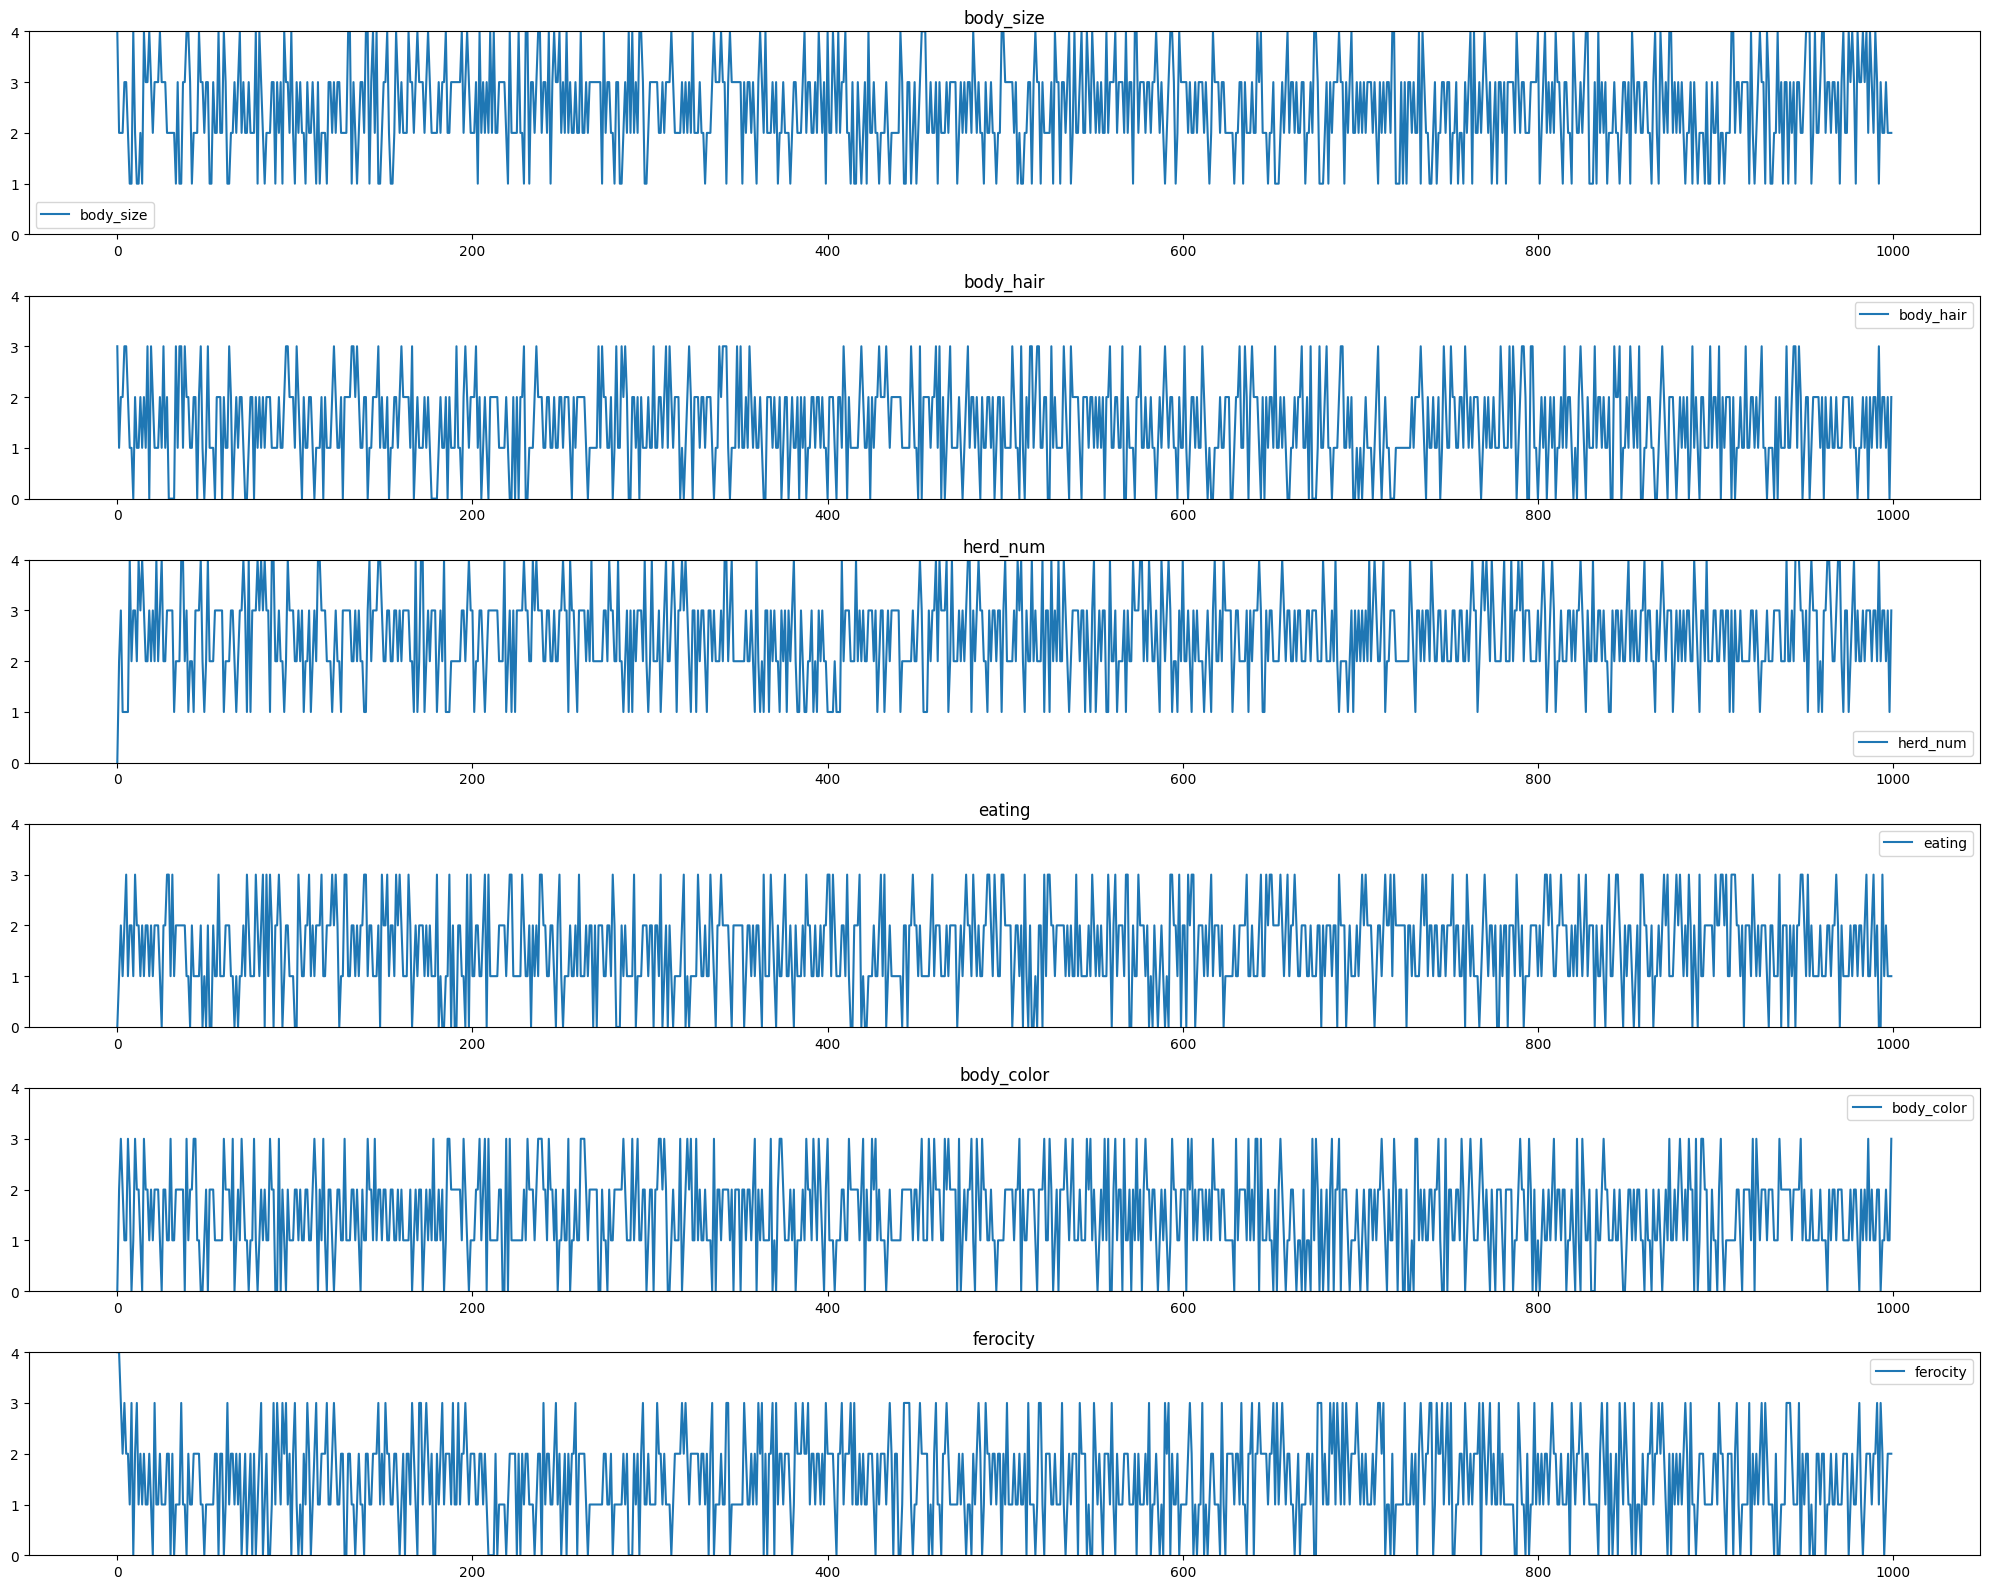

In [4]:
# キーワード候補
word_dict = {
    "body_size": ["Fingertip sized", "Palm sized", "", "Tall", "Giant"],
    "body_hair": ["Bald", "Smooth", "", "Furry", "Very Furry"],
    "herd_num":	["Lone", "Pair", "", "Herd of", "Swarm of"],
    "eating": ["No teeth", "Herbivorous", "Omnivorous", "Carnivorous", "Fang"],
    "body_color": ["Lightest skin", "Lighter skin", "", "Darker skin", "Darkest skin"],
    "ferocity": ["Peaceful", "Gentle", "", "Ferocious", "Tyrannical"],
}

# create first genetarion
generation = create_generation(POPURATIONS, GENOMS_SIZE)

# アルゴリズムの実行
best, worst = ga_solve(generation, NUM_GENERATION, POPURATIONS, TOUNAMENT_NUM, CROSSOVER_PB, MUTATION_PB)

## 画像生成

### Hugging Face へのログイン

In [5]:
notebook_login()
!git config --global credential.helper store

Login successful
Your token has been saved to /Users/shimizukouji/.huggingface/token


### 画像生成モデルのダウンロード

In [7]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

device = "gpu" if torch.cuda.is_available() else "cpu"

print("used device is", device)
pipe.to(device)

# NSFWフィルターの回避
def null_safety(images, **kwargs):
    return images, False
 
pipe.safety_checker = null_safety

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


used device is cpu


### 画像生成の実行

最初の世代: Very Furry Tall Herd of No teeth Lighter skin Ferocious Alien from Mars 



  0%|          | 0/51 [00:00<?, ?it/s]

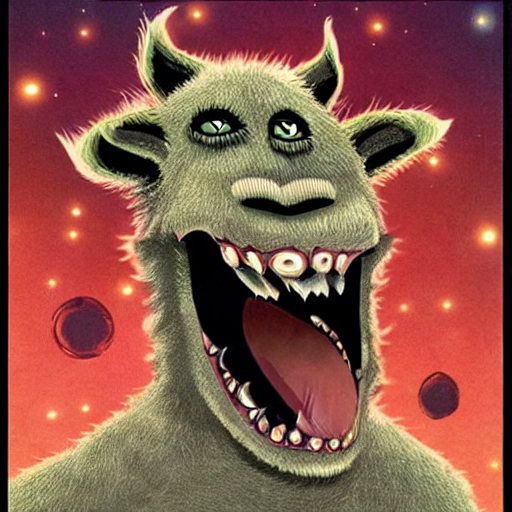

中間の500世代目:  Giant Herd of Carnivorous Lighter skin  Alien from Mars 



  0%|          | 0/51 [00:00<?, ?it/s]

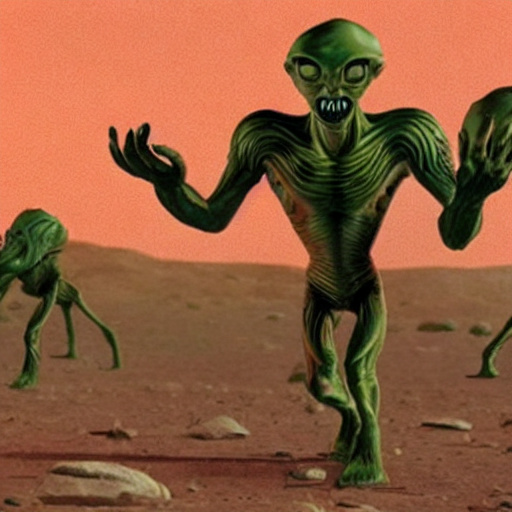

最後の1000世代目: Bald  Pair Herbivorous Lighter skin  Alien from Mars 



  0%|          | 0/51 [00:00<?, ?it/s]

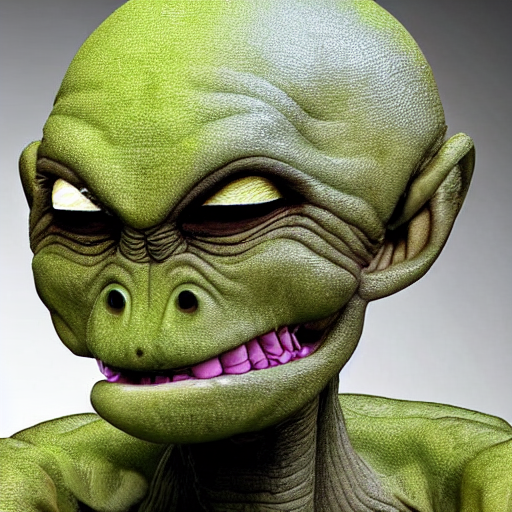

In [9]:
# 抽出する世代
first_generation = 0
middle_generation = len(best) // 2
last_generation = -1


# 初代の画像を生成
first_generation_word = get_word_for_image_generate(word_dict, best, first_generation) + HABITAT_WORDS
print("最初の世代:", first_generation_word, "\n")

images = pipe(first_generation_word)["sample"]

for image in images:
    display(image)
    image.save(f"{first_generation}_th.png")


# 中間世代の画像を生成
middle_generation_word = get_word_for_image_generate(word_dict, best, middle_generation) + HABITAT_WORDS
print(f"中間の{middle_generation}世代目:", middle_generation_word, "\n")

images = pipe(middle_generation_word)["sample"]
for image in images:
    display(image)
    image.save(f"{middle_generation}_th.png")


# 最終世代の画像を生成
last_generation_word = get_word_for_image_generate(word_dict, best, last_generation) + HABITAT_WORDS
print(f"最後の{NUM_GENERATION}世代目:", last_generation_word, "\n")

images = pipe(last_generation_word)["sample"]
for image in images:
    display(image)
    image.save(f"{NUM_GENERATION}_th.png")